In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from MINE import MINE_Model
from tqdm import tqdm

/Applications/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Generate data of two dependent variables with non zero MI. Compute the MI analytically so the accuracy of MINE can be checked.

In [1]:
# data
var = 0.2

def gen_x(data_size=2000):
    return np.sign(np.random.normal(0.,1.,[data_size,1]))

def gen_y(x,data_size=2000):
    return x + np.random.normal(0.,np.sqrt(var),[data_size,1])

# generate the data
x = gen_x()
y = gen_y(x)

# Look at the probability distributions.
p_y_x = np.exp(-(y-x)**2/(2*var))
p_y_x_minus = np.exp(-(y+1)**2/(2*var))
p_y_x_plus = np.exp(-(y-1)**2/(2*var))

mi=np.average(np.log(p_y_x/(0.5*p_y_x_minus+0.5*p_y_x_plus)))
print(mi)

NameError: name 'np' is not defined

Construct the MINE network and train it. Plot convergence of the loss towards true MI.

100%|██████████| 200/200 [00:02<00:00, 85.77it/s]
/Applications/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


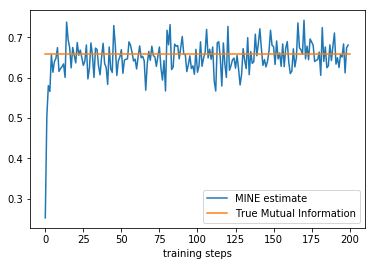

In [6]:
tf.reset_default_graph()
n_hiddens=[20,20,20]
n_epochs = 200
num_train_ex = 1000
batch_size=100
steps_per_epoch=(int(num_train_ex/batch_size))

mine = MINE_Model(3,n_hiddens)

# prepare the placeholders for inputs
x_in = tf.placeholder(tf.float32, [batch_size, 1], name='x_in')
y_in = tf.placeholder(tf.float32, [batch_size, 1], name='y_in')

# make the loss and optimisation graphs
neg_loss = mine.loss([x_in, y_in])

opt = tf.train.AdamOptimizer(learning_rate=0.01).minimize(neg_loss,var_list=[mine.variables()])

# start the session
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

def get_train_data(data,step,batch_size):
    ind1=step*batch_size
    return data[ind1:(ind1+batch_size)]

# train
MIs = []
for epoch in tqdm(range(n_epochs)):
    total_loss=[]
    # generate the data
    shuffle = np.random.permutation(num_train_ex)
    x_dat = gen_x(data_size=num_train_ex)[:]
    y_dat = gen_y(x_dat,data_size=num_train_ex)[:]
    for step in range(steps_per_epoch):
        # make batches
        x_sample = get_train_data(x_dat,step,batch_size)
        y_sample = get_train_data(y_dat,step,batch_size)
        # perform the training step
        feed_dict = {x_in:x_sample, y_in:y_sample}
        _, neg_l = sess.run([opt, neg_loss], feed_dict=feed_dict)
        total_loss+=[neg_l]
    
    # save the loss
    MIs.append(-np.mean(total_loss))

fig, ax = plt.subplots()
ax.plot(range(len(MIs)), MIs, label='MINE estimate')
ax.plot([0, len(MIs)], [mi,mi], label='True Mutual Information')
ax.set_xlabel('training steps')
ax.legend(loc='best')
# fig.savefig('MINE.png')
fig.show()
